In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_filtered.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_filtered.tsv')
THE_NUMBERS_PATH_YEARLY = os.path.join(DATA_PATH, 'the_numbers_cleaned_yearly.tsv')

## 1.1 Chars dataset

In [4]:
df_chars = pd.read_csv(CHAR_PATH, sep='\t')
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars.head(2)

,wikipedia_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,m_name,m_genre_PCA
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,Ghosts of Mars,"'Documentary', 'Culture & Society', 'Gay', 'So..."
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,Ghosts of Mars,"'Documentary', 'Culture & Society', 'Gay', 'So..."


## 1.2 The numbers data yearly

In [5]:
df_numbers_yearly = pd.read_csv(THE_NUMBERS_PATH_YEARLY, sep='\t').set_index('actor_name')
df_numbers_yearly.columns = df_numbers_yearly.columns.astype(int)
df_numbers_yearly.head(2)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,99.0,99.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,0.0,16.0,0.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0
Clint Eastwood,174.0,0.0,86.0,94.0,167.0,82.0,83.0,0.0,72.0,28.0,...,0.0,0.0,0.0,0.0,0.0,71.0,0.0,0.0,36.0,0.0


# 2. The numbers preparation

In [6]:
columns = df_numbers_yearly.columns
def get_min_year(row):
    for x in columns[:-2]:
        if row[x]>0:
            return x
    return 0

In [7]:
def get_min_year_score(row):
    for x in columns[:-2]:
        if row[x] >0:
            return float(row[x])
    return 0

In [8]:
df_numbers_yearly['min_year'] = df_numbers_yearly.apply(lambda row: get_min_year(row), axis=1)
df_numbers_yearly['min_year_score'] = df_numbers_yearly.apply(lambda row: get_min_year_score(row), axis=1)
df_numbers_yearly.head(3)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,min_year,min_year_score
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,99.0,99.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,...,0.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,1980,99.0
Clint Eastwood,174.0,0.0,86.0,94.0,167.0,82.0,83.0,0.0,72.0,28.0,...,0.0,0.0,0.0,71.0,0.0,0.0,36.0,0.0,1980,174.0
John Belushi,92.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1980,92.0


## 2.1 Actors existing in characters dataset

In [9]:
#Keep only actors that appear in the characters dataset
df_numbers_yearly = df_numbers_yearly.merge(df_chars.drop_duplicates('actor_name', keep='first')[['actor_name']], on='actor_name')
df_numbers_yearly.shape[0]

1995

## 2.2 Number of movies per actor per year

In [10]:
df_chars['m_release_year'] = df_chars['m_release_date'].dt.year

In [11]:
columns = ['actor_name', 'min_year']
df_chars = df_chars.merge(df_numbers_yearly.reset_index()[columns], on='actor_name', how='left')

In [12]:
#map_nb_movies_per_year = df_chars.groupby(['m_release_year', 'actor_name'])['wikipedia_m_ID'].count().reset_index()
#map_nb_movies_per_year

In [13]:
map_nb_movies_per_year = df_chars.groupby(['m_release_year', 'actor_name']).agg({'wikipedia_m_ID': 'count', 'min_year':'first'}).reset_index()
map_nb_movies_per_year

,m_release_year,actor_name,wikipedia_m_ID,min_year
0,1896,John C. Rice,1,NaN
1,1896,May Irwin,1,NaN
2,1903,Arthur White,1,NaN
3,1903,Broncho Billy Anderson,1,NaN
4,1903,Donald Gallaher,1,NaN
...,...,...,...,...
139022,2012,Zoe Saldana,1,2002.0
139023,2012,Zohren Weiss,1,NaN
139024,2012,Zoë Bell,1,NaN
139025,2012,Óscar Jaenada,1,NaN


In [14]:
nb_years = range(1980, 2013)
list_years = dict()
for y in nb_years:
    filter_conditions=(
        map_nb_movies_per_year['m_release_year'] <= y
    )
    l_year = map_nb_movies_per_year[filter_conditions]
    l_year = l_year.groupby('actor_name')['wikipedia_m_ID'].sum().reset_index()
    l_year['wikipedia_m_ID'] =l_year['wikipedia_m_ID'].astype(int)
    l_year.rename({'wikipedia_m_ID': 'nb_movies_until_{}'.format(y)}, axis=1, inplace=True)
    list_years.update({y: l_year})

In [15]:
nb_years = range(1980, 2013)
list_years_revealed = dict()
for y in nb_years:
    filter_conditions=(
        (map_nb_movies_per_year['m_release_year'] <= y) &
        (map_nb_movies_per_year['min_year'] <= map_nb_movies_per_year['m_release_year'])
    )
    l_year = map_nb_movies_per_year[filter_conditions]
    l_year = l_year.groupby('actor_name')['wikipedia_m_ID'].sum().reset_index()
    l_year['wikipedia_m_ID'] =l_year['wikipedia_m_ID'].astype(int)
    l_year.rename({'wikipedia_m_ID': 'nb_movies_after_revelation_until_{}'.format(y)}, axis=1, inplace=True)
    list_years_revealed.update({y: l_year})

In [16]:
for key, year in list_years.items():
    df_numbers_yearly = df_numbers_yearly.merge(year, on='actor_name', how='left')
    df_numbers_yearly['nb_movies_until_{}'.format(key)] = df_numbers_yearly['nb_movies_until_{}'.format(key)].fillna(0).astype(int)
    
for key, year in list_years_revealed.items():
    df_numbers_yearly = df_numbers_yearly.merge(year, on='actor_name', how='left')
    df_numbers_yearly['nb_movies_after_revelation_until_{}'.format(key)] = df_numbers_yearly['nb_movies_after_revelation_until_{}'.format(key)].fillna(0).astype(int)
df_numbers_yearly.head()

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,nb_movies_after_revelation_until_2003,nb_movies_after_revelation_until_2004,nb_movies_after_revelation_until_2005,nb_movies_after_revelation_until_2006,nb_movies_after_revelation_until_2007,nb_movies_after_revelation_until_2008,nb_movies_after_revelation_until_2009,nb_movies_after_revelation_until_2010,nb_movies_after_revelation_until_2011,nb_movies_after_revelation_until_2012
0,Jane Fonda,99.0,99.0,0.0,0.0,0.0,0.0,63.0,0.0,0.0,...,10,10,11,11,12,12,12,12,14,14
1,Clint Eastwood,174.0,0.0,86.0,94.0,167.0,82.0,83.0,0.0,72.0,...,23,24,24,24,25,26,26,26,26,27
2,John Belushi,92.0,125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,3,3,3,3,3,3,3,3,3
3,Burt Reynolds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12,13,17,21,23,25,25,25,26,26
4,Goldie Hawn,170.0,0.0,81.0,0.0,66.0,0.0,66.0,59.0,0.0,...,17,17,17,17,17,17,17,17,17,17


In [17]:
# we don't need scores avec 2012
columns_to_drop = [y for y in range(2013, 2023)]
df_numbers_yearly.drop(columns_to_drop, axis=1, inplace=True)

# 3 Score computation

In [18]:
years = [y for y in range(2012, 1979, -1)]
nb_movies = ['nb_movies_after_revelation_until_{}'.format(y) for y in range(2012, 1979, -1)]

In [19]:
def compute_weight(row):
    one_year=0
    actor_score_weighted=[]
    list_scores = row[years]
    weights = row[nb_movies]
    for i, year_out in enumerate(list_scores):
        one_year=0
        for dist, (score, weight) in enumerate(zip(list_scores[i:], weights[i:]), start=1):
            one_year=one_year+score*weight/dist
        actor_score_weighted.append(one_year)
    actor_score_weighted.reverse()
    return actor_score_weighted

In [20]:
%%time
df_yearly_decayed = df_numbers_yearly.apply(lambda row: compute_weight(row), axis=1).to_frame()

CPU times: total: 6.64 s
Wall time: 6.78 s


In [21]:
df_numbers_yearly.set_index('actor_name', inplace=True)
years.reverse()

In [22]:
df_yearly_decayed=pd.DataFrame(df_yearly_decayed[0].to_list(), columns=years).copy()
df_yearly_decayed['actor_name'] = df_numbers_yearly.index.values
df_yearly_decayed.set_index('actor_name', inplace=True)

In [23]:
df_yearly_decayed = df_yearly_decayed.loc[~(df_yearly_decayed==0).all(axis=1)]

In [24]:
df_yearly_decayed.reset_index(inplace=True)

In [25]:
filter_conditions=(
    (df_yearly_decayed['actor_name'] == 'Burt Reynolds') | 
    (df_yearly_decayed['actor_name'] == 'Denzel Washington') |
    (df_yearly_decayed['actor_name'] == 'Meryl Streep') |
    (df_yearly_decayed['actor_name'] == 'Bruce Willis')
)
df_yearly_decayed.loc[filter_conditions]

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
3,Burt Reynolds,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,...,14.857143,13.000000,2799.555556,1404.400000,938.787879,705.666667,565.600000,472.095238,405.219048,355.000000
18,Meryl Streep,0.0,0.0,148.0,320.0,284.333333,751.0,864.433333,517.866667,377.87619,...,1168.239338,926.633319,788.376528,3382.726084,1969.270508,5418.813094,8914.494664,5214.388815,3807.210202,5433.933031
322,Bruce Willis,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,75.000000,319.50000,...,6837.117523,5275.770486,8609.241538,6663.609501,10071.305226,6811.595987,6950.876427,11341.698926,7555.336701,12138.982689
396,Denzel Washington,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,...,4101.144811,6480.237531,4207.311607,7413.886729,7901.676182,5289.325816,5804.717693,8748.336365,5788.651092,9897.153187


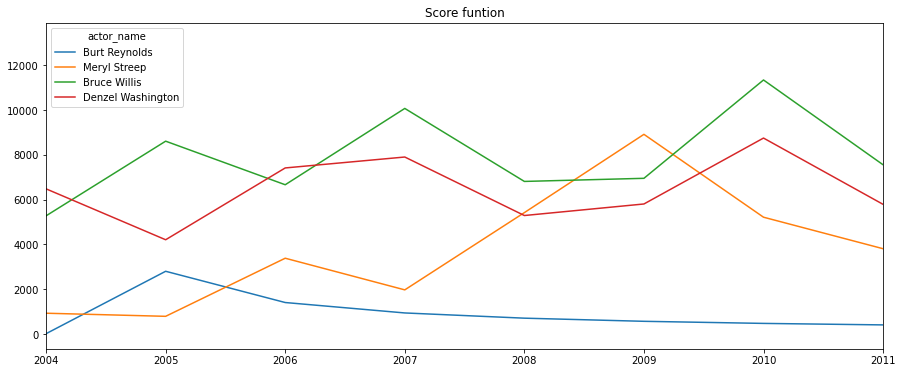

In [26]:
a = df_yearly_decayed.loc[filter_conditions].T
a.columns = a.iloc[0]

a = a.iloc[1: , :]
a.plot(figsize=(15, 6))
plt.xlim(2004, 2011)
plt.title("Score funtion")
plt.show()

In [27]:
nb_new_actors = dict()
for y in df_yearly_decayed.columns[1:]:
    nb = (df_yearly_decayed[y]==0).sum()
    nb_new_actors.update({y: nb})

<BarContainer object of 33 artists>

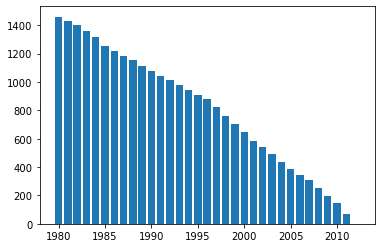

In [28]:
plt.bar(nb_new_actors.keys(), nb_new_actors.values())

In [29]:
df_yearly_decayed=df_yearly_decayed.copy()
df_yearly_decayed['min_year'] = df_yearly_decayed.apply(lambda row: get_min_year(row), axis=1)
df_yearly_decayed['min_year_score'] = df_yearly_decayed.apply(lambda row: get_min_year_score(row), axis=1)
df_yearly_decayed.head(3)

,actor_name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2005,2006,2007,2008,2009,2010,2011,2012,min_year,min_year_score
0,Jane Fonda,99.0,346.5,181.500000,123.75,94.050000,75.900000,441.642857,243.803571,174.125000,...,892.587692,462.089744,317.717532,244.955719,200.891379,171.213548,149.784285,133.531250,0,0
1,Clint Eastwood,348.0,174.0,460.000000,729.00,1755.266667,1706.666667,1880.347619,1189.833333,1686.509524,...,2139.009068,1715.610398,1470.104342,3616.394846,2334.278040,1850.068876,1576.740235,1825.545952,0,0
2,John Belushi,92.0,421.0,218.166667,148.00,112.150000,90.333333,75.642857,65.071429,57.097222,...,18.538462,17.830484,17.174603,16.565271,15.997701,15.467742,14.971774,14.506629,0,0


## 3. Output as clean CSV

In [31]:
OUTPUT_FILE_NUMBERS = 'the_numbers_yearly_score.tsv'
OUTPUT_PATH = os.path.join(DATA_PATH, OUTPUT_FILE_NUMBERS)
df_yearly_decayed.to_csv(OUTPUT_PATH, sep="\t", index=False)